# Programming Integration Project - Semester 251

### Students
- Nguyễn Văn An --- Student ID: 2352013
- Hoàng Kim Cương --- Student ID: 2352145

### Video Presentation
- Our group's presentation can be viewed here: https://www.youtube.com/watch?v=JwhVhIja_9M

- The slides we used for our presentation can be viewed here: https://www.canva.com/design/DAG7Nmcjac8/0vaQe_hqMMY-RypLO3plRA/view?utm_content=DAG7Nmcjac8&utm_campaign=designshare&utm_medium=link2&utm_source=uniquelinks&utlId=h86f9c836a9

### Description
This is the Notebook for our Project. It consists of a full workflow, from importing data to training and benchmarking results.

For data pre-processing code, we take a look at preprocess.py

In [1]:
import os
import numpy as np
import random
import pandas
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score


from resnet import ResNet18, ResidualBlock
from mobilenet import MobileNetV1, MobileNetV2
from vggnet import VGG16
from data import ImgDataset

## Setup and Input Phase

### We employ a "standard" process:

- A seed value of 42
- A device to run the training which priorizes GPU if available
- Finally, some code to reduce randomness during training

In [2]:
seed = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reproducibility settings
torch.manual_seed(seed)
np.random.seed(seed)
# torch.use_deterministic_algorithms(True)
# os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

print(f"Using device: {device}")

Using device: cuda


In [3]:
CSV_PATH = "/home/banana9205/Desktop/Main/Uni/DATH/Dataset/plantvillage dataset/dataframes"
IMG_PATH = "/home/banana9205/Desktop/Main/Uni/DATH/Dataset/plantvillage dataset"
TRAIN_IMG = os.path.join(IMG_PATH, "train")
VAL_IMG = os.path.join(IMG_PATH, "val")
TEST_IMG = os.path.join(IMG_PATH, "test")

### Some note on why we need a test set and why we can't just use the evaluate set for final benchmark:
- Generally, when we're in evaluation phase, i.e. the part during model.eval(), we do not update the weights of the model. 
- However, we do train the model indirectly by making decisions (for example, choosing the best model to keep, and early stopping,...)
- Therefore, in some sense we have "leaked" information from the evaluate set into the model.
- The test set is thus created, to act as never-seen-before data and give us an unbiased evaluation of our final model.

In [4]:
train_csv_path = os.path.join(CSV_PATH, "train_labels.csv")
val_csv_path = os.path.join(CSV_PATH, "val_labels.csv")
test_csv_path = os.path.join(CSV_PATH, "test_labels.csv")

print(f"Path to training CSV: {train_csv_path}")
print(f"Path to validation CSV: {val_csv_path}")
print(f"Path to test CSV: {test_csv_path}")

train_csv = pandas.read_csv(train_csv_path)
val_csv = pandas.read_csv(val_csv_path)
test_csv = pandas.read_csv(test_csv_path)

Path to training CSV: /home/banana9205/Desktop/Main/Uni/DATH/Dataset/plantvillage dataset/dataframes/train_labels.csv
Path to validation CSV: /home/banana9205/Desktop/Main/Uni/DATH/Dataset/plantvillage dataset/dataframes/val_labels.csv
Path to test CSV: /home/banana9205/Desktop/Main/Uni/DATH/Dataset/plantvillage dataset/dataframes/test_labels.csv


## Normalization for each channel (R, G, B)

Some notes on why normalization is important:
- Normalization, in this case, brings the pixel values to approximately [-1, 1] range.

- If left unnormalized, pixel values would be in [0, 255] range after ToTensor(), which can lead to skewed activations in the network and large variance/unstable gradients.
   
- A [-1, 1] range (hopefully) makes things easier for the model, as it centers the data around 0 and is symmetric, which helps with convergence during training, as gradients are more balanced.

If we want actual optimal values (i.e. true N(0, 1) normalization for this specific dataset), we would have to compute mean and std over our dataset. This requires us to:
- Load every image.
- Convert them to tensors.
- For one image, we have to compute 256 x 256 x 3 = 196608 pixels. Do that over ~10000 images and we would have to spend a lot of time just for calculation alone. 

Instead, we can use the statistics from ImageNet because it contains enough images related to our dataset to work as a solid approximation. The commonly used values are:
- Mean 0.485 and Std 0.229 for Red channels
- Mean 0.456 and Std 0.224 for Green channels
- Mean 0.406 and Std 0.225 for Blue channels

### Here we provide 3 modes of data augmentation for training dataset
- Mild augmentation: horizontal and vertical flips
- Moderate augmentation: flips + random rotations + crops + color jitter
- Aggressive augmentation: flips + random rotations + crops + color jitter + gaussian blur

In [5]:
stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

mild_transform = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),

    T.ToTensor(),
    T.Normalize(*stats)
])

moderate_transform = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),

    T.RandomRotation(90),
    T.RandomResizedCrop(256, scale=(0.8, 1.0)),
    T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.02),

    T.ToTensor(),
    T.Normalize(*stats)
])

aggressive_transform = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),

    T.RandomRotation(180),
    T.RandomResizedCrop(256, scale=(0.3, 1.0)),
    T.ColorJitter(brightness=0.6, contrast=0.6, saturation=0.6, hue=0.03),

    T.RandomApply([T.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0))], p=0.5),

    T.ToTensor(),
    T.Normalize(*stats)
])

# Also some transformations for validation and test datasets
val_test_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(*stats)
])

### We divide the training dataset into 3 different augmentation levels
   - 60% of them use mild augmentation
   - 30% of them use moderate augmentation
   - 10% of them use aggressive augmentation

Our splitting strategy here would be to take every image in the same class and split them into each mode of augmentation. This strategy is called a Stratified Split.

In [6]:
all_data = pandas.concat([train_csv, val_csv, test_csv])
master_classes = (
    all_data[["plant", "disease"]]
    .drop_duplicates()
    .sort_values(["plant", "disease"], ignore_index=True)
)


# Deterministically shuffle the training dataframe
train_csv_shuffled = train_csv.sample(frac=1, random_state=seed).reset_index(drop=True)

# Lists to hold the dataframe chunks
mild_chunks = []
moderate_chunks = []
aggressive_chunks = []

# Group by (plant, disease) so we can split each class individually
grouped = train_csv.groupby(['plant', 'disease'])

for _, group in grouped:
    num_samples = len(group)
    mild_end = int(0.6 * num_samples)
    moderate_end = int(0.9 * num_samples)

    mild_chunks.append(group.iloc[:mild_end])
    moderate_chunks.append(group.iloc[mild_end:moderate_end])
    aggressive_chunks.append(group.iloc[moderate_end:])

train_mild_df = pandas.concat(mild_chunks)
train_moderate_df = pandas.concat(moderate_chunks)
train_aggressive_df = pandas.concat(aggressive_chunks)

train_ds_mild = ImgDataset(train_mild_df, TRAIN_IMG, transform=mild_transform, classes=master_classes)
train_ds_moderate = ImgDataset(train_moderate_df, TRAIN_IMG, transform=moderate_transform, classes=master_classes)
train_ds_aggressive = ImgDataset(train_aggressive_df, TRAIN_IMG, transform=aggressive_transform, classes=master_classes)

train_ds = torch.utils.data.ConcatDataset([train_ds_mild, train_ds_moderate, train_ds_aggressive])
val_ds = ImgDataset(val_csv, VAL_IMG, transform=val_test_transform, classes=master_classes)
test_ds = ImgDataset(test_csv, TEST_IMG, transform=val_test_transform, classes=master_classes)

num_classes = len(master_classes)

print(f"Total distinct classes: {len(master_classes)}")
print(train_ds_mild.classes)
print(f"Mild samples: {len(train_ds_mild)} samples with {len(train_ds_mild.classes)} classes,\n"
      f"Moderate: {len(train_ds_moderate)} samples with {len(train_ds_moderate.classes)} classes,\n"
      f"Aggressive: {len(train_ds_aggressive)} samples with {len(train_ds_aggressive.classes)} classes")

Total distinct classes: 19
           plant                              disease
0          Apple                           Apple_scab
1          Apple                            Black_rot
2          Apple                     Cedar_apple_rust
3          Apple                              healthy
4   Corn_(maize)  Cercospora_leaf_spot Gray_leaf_spot
5   Corn_(maize)                         Common_rust_
6   Corn_(maize)                 Northern_Leaf_Blight
7   Corn_(maize)                              healthy
8          Grape                            Black_rot
9          Grape                 Esca_(Black_Measles)
10         Grape   Leaf_blight_(Isariopsis_Leaf_Spot)
11         Grape                              healthy
12         Peach                       Bacterial_spot
13         Peach                              healthy
14        Potato                         Early_blight
15        Potato                          Late_blight
16        Potato                              healthy
1

### Then we define the configurations for each model to be trained, alongside global training parameters

### Some note on the Optimizer
Adam is an optimization algorithm that combines the best properties of two previous algorithms: Momentum (which stabilizes the direction of the update) and RMSProp (which adapts the step size for each parameter). Basically it combines physics-inspired methods to create an optimizer that adapts the learning rate individually for every single parameter in the network.

Adam trained very fast, but it often generalized worse than simple Stochastic Gradient Descent, because it applied L2 regularization incorrectly (by entangling it with the adaptive learning rates). AdamW essentially fixes the issue by decoupling the weight decay from the gradient updates.

We use the parameter weight_decay to indicate L2 regularization, which acts as a penalty against model complexity.
- Mathematically, it effectively subtracts a tiny fraction of the weight's current value at every step: $w_{new} = w_{old} - \eta \cdot \lambda \cdot w_{old}$ (where $\lambda$ is weight decay and $\eta$ is the learning rate).

- This forces the model's weights to remain small (close to zero). By preventing any single neuron from having an overly dominant weight, we discourage the model from memorizing noise in the training data (overfitting), resulting in a smoother decision boundary.

In [7]:
# Training configs
MODEL_DIR = os.path.join("/home/banana9205/Desktop/Main/Uni/DATH/models")

batch_size = 32
lr = 2e-4
weight_decay = 1e-3

model_configs = [
    {
        "name": "ResNet18",
        "model": ResNet18(block=ResidualBlock, blocks_per_layer=[2, 2, 2, 2], n_channels=3, n_classes=num_classes),
        "epochs": 10,
        "patience": 3,
        "device": device
    },
    {
        "name": "MobileNetV1",
        "model": MobileNetV1(n_channels=3, n_classes=num_classes),
        "epochs": 15,
        "patience": 5,
        "device": device
    },
    {
        "name": "MobileNetV2",
        "model": MobileNetV2(n_channels=3, n_classes=num_classes),
        "epochs": 15,
        "patience": 5,
        "device": device
    },
    # This model was too large to fit in GPU memory (more than 100 million parameters)
    # {
    #     "name": "VGG16",
    #     "model": VGG16(n_channels=3, n_classes=num_classes),
    #     "epochs": 10,
    #     "patience": 3,
    #     "device": device
    # }
]

### We define the seed_worker function to ensure reproducibility across multiple DataLoader workers.

When we use num_workers > 0 in PyTorch's DataLoader, it spawns multiple subprocesses to load data in parallel. Each worker process has its own random state, which can lead to:

- Non-deterministic data augmentation (flips, rotations, crops,... will produce different results across runs)
- Non-deterministic shuffling (even with the same global seed, workers may shuffle data differently)
- Inconsistent results (training results won't be reproducible)

### seed_worker derives a unique but deterministic seed for each worker based on the global seed, thus ensures each worker produces the same random sequence across different runs

In [8]:
def seed_worker(worker_id):
    # Derive a unique seed for this worker based on the global seed
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# Create a deterministic generator for the DataLoader
g = torch.Generator()
g.manual_seed(seed)  # Uses the global 'seed' variable (42)

train_loader = DataLoader(train_ds, batch_size=batch_size, 
                          shuffle=True, num_workers=4, 
                          worker_init_fn=seed_worker, generator=g)

val_loader   = DataLoader(val_ds, batch_size=batch_size, 
                          shuffle=False, num_workers=4, 
                          worker_init_fn=seed_worker, generator=g)

test_loader  = DataLoader(test_ds, batch_size=batch_size, 
                          shuffle=False, num_workers=4, 
                          worker_init_fn=seed_worker, generator=g)

## Training and Evaluation Phases

Our main metrics will be the F1 Score, specifically the Macro F1 Score which is the average of the F1 Scores of all classes.

As mentioned before, we will train the models on 70% of the data, evaluate on 15% of them and test on the remaining 15%.

### Some note on the importance of F1 Score

F1 Score is the harmonic mean of precision and recall, where:
$$ \text{Precision} = \text{True Positives} / (\text{True Positives} + \text{False Positives}) $$

- Of the cases predicted as positive, how many were actually positive?
  
$$ \text{Recall} = \text{True Positives} / (\text{True Positives} + \text{False Negatives}) $$
  - Of all actual positive cases, how many did the model find? 

(Note: Recall is calculated PER CLASS while Accuracy is calculated GLOBALLY)

Then, F1 Score is mathematically defined as:
$$ F1 = 2 \times (\text{Precision} \times \text{Recall}) / (\text{Precision} + \text{Recall}) $$

#### Why Not Just Use Accuracy?

Accuracy can be misleading with imbalanced datasets. For example:

If we have 100 plants, 95 of which are healthy and the remaining 5 have diseases. A naive model that always predicts "healthy" achieves:
- Accuracy:   $\quad 95 / (95 + 5) = 0.95 $
- Precision:
  - For "healthy":   $\quad 95 / (95 + 5) = 0.95$
  - For "disease":   $\quad 0 / (0 + 0) = 0$, by convention
- Recall:
  - For "healthy":   $\quad 95 / (95 + 0) = 1$
  - For "disease":   $\quad 0 / (0 + 5) = 0$
- F1 Score:
  - For "healthy":   $\quad 2 * 0.95 * 1 / (0.95 + 1) = 0.974$
  - For "disease":   $\quad 2 * 0 * 0 / (0 + 0) = 0$, by convention
  - The Macro F1 Score is just $\; 0.487$, which determines it's a bad model.

Thus, using Macro F1 Score ensures our saved model performs well across all disease types, not just the most common ones.

In [9]:
def train_and_evaluate(config):
    """
    A helper function to train and evaluate a model based on the provided configuration.
    Args: config (dict): A dictionary containing the following keys:
        - "name": Name of the model (str)
        - "model": The PyTorch model instance (nn.Module)
        - "epochs": Number of training epochs (int)
        - "patience": Patience for early stopping (int)
    """
    name = config["name"]
    model = config["model"].to(device)
    num_epochs = config["epochs"]
    patience = config["patience"]
    
    print(f"\n{'='*40}\nTraining {name}\n{'='*40}")
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    best_val_acc = 0.0
    best_val_f1 = 0.0
    epochs_no_improve = 0

    # Dictionary to store history
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_acc': [],
        'val_f1': []
    }
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss, correct, total = 0, 0, 0

        for images, labels in tqdm(train_loader, desc=f"[Train] Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        avg_train_loss = train_loss / len(train_loader)
        train_acc = correct / total * 100
        
        # Validation phase (Accuracy + F1 Score)
        model.eval()
        val_loss, correct, total = 0, 0, 0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        avg_val_loss = val_loss / len(val_loader)
        val_acc = correct / total * 100
        val_f1 = f1_score(all_labels, all_preds, average='weighted')

        # Record history to plot later
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)
        
        print(f"Results: Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
        print(f"         Train Acc:  {train_acc:.2f}%   | Val Acc:  {val_acc:.2f}%   | Val F1:   {val_f1:.4f}")

        # Early stopping check
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_val_acc = val_acc
            epochs_no_improve = 0
            save_path = os.path.join(MODEL_DIR, f"{name}_best.pth")
            torch.save(model.state_dict(), save_path)
            print(f"Best model saved.")
        else:
            epochs_no_improve += 1
            print(f"No improvement for {epochs_no_improve}/{patience} epochs.")
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered for {name}!")
                break

    return best_val_acc, best_val_f1, history

In [10]:
# Main training loop for all model configurations
models_to_train = ["ResNet18", "MobileNetV1", "MobileNetV2"]
results = {}
model_histories = {}

for config in model_configs:
    if config["name"] not in models_to_train:
        continue
    val_acc, val_f1, history = train_and_evaluate(config)
    model_histories[config["name"]] = history
    results[config["name"]] = (val_acc, val_f1)
    
print("\nFinal Metrics of Models:")
for name, (acc, f1) in results.items():
    print(f"{name}: {acc:.2f}% | {f1:.2f}%")


Training ResNet18


Epoch 1/10 [Val]: 100%|██████████| 83/83 [00:04<00:00, 17.72it/s]


Results: Train Loss: 1.1667 | Val Loss: 0.5262
         Train Acc:  63.18%   | Val Acc:  81.53%   | Val F1:   0.8064
Best model saved.


Epoch 2/10 [Val]: 100%|██████████| 83/83 [00:04<00:00, 17.11it/s]


Results: Train Loss: 0.6809 | Val Loss: 0.3485
         Train Acc:  77.79%   | Val Acc:  87.74%   | Val F1:   0.8746
Best model saved.


Epoch 3/10 [Val]: 100%|██████████| 83/83 [00:05<00:00, 15.68it/s]


Results: Train Loss: 0.4677 | Val Loss: 0.2723
         Train Acc:  84.92%   | Val Acc:  91.17%   | Val F1:   0.9114
Best model saved.


Epoch 4/10 [Val]: 100%|██████████| 83/83 [00:05<00:00, 13.86it/s]


Results: Train Loss: 0.3558 | Val Loss: 0.1486
         Train Acc:  88.59%   | Val Acc:  94.94%   | Val F1:   0.9491
Best model saved.


Epoch 5/10 [Val]: 100%|██████████| 83/83 [00:04<00:00, 17.85it/s]


Results: Train Loss: 0.2856 | Val Loss: 0.1764
         Train Acc:  90.87%   | Val Acc:  94.14%   | Val F1:   0.9402
No improvement for 1/3 epochs.


Epoch 6/10 [Val]: 100%|██████████| 83/83 [00:05<00:00, 15.05it/s]


Results: Train Loss: 0.2369 | Val Loss: 0.1113
         Train Acc:  92.44%   | Val Acc:  96.42%   | Val F1:   0.9627
Best model saved.


Epoch 7/10 [Val]: 100%|██████████| 83/83 [00:04<00:00, 17.64it/s]


Results: Train Loss: 0.2033 | Val Loss: 0.1441
         Train Acc:  93.39%   | Val Acc:  94.78%   | Val F1:   0.9486
No improvement for 1/3 epochs.


Epoch 8/10 [Val]: 100%|██████████| 83/83 [00:07<00:00, 11.83it/s]


Results: Train Loss: 0.1970 | Val Loss: 0.1409
         Train Acc:  93.58%   | Val Acc:  94.40%   | Val F1:   0.9441
No improvement for 2/3 epochs.


Epoch 9/10 [Val]: 100%|██████████| 83/83 [00:07<00:00, 11.00it/s]


Results: Train Loss: 0.1743 | Val Loss: 0.0872
         Train Acc:  94.38%   | Val Acc:  97.45%   | Val F1:   0.9747
Best model saved.


Epoch 10/10 [Val]: 100%|██████████| 83/83 [00:07<00:00, 11.32it/s]


Results: Train Loss: 0.1505 | Val Loss: 0.1036
         Train Acc:  95.26%   | Val Acc:  96.65%   | Val F1:   0.9653
No improvement for 1/3 epochs.

Training MobileNetV1


Epoch 1/15 [Val]: 100%|██████████| 83/83 [00:04<00:00, 18.73it/s]


Results: Train Loss: 2.2213 | Val Loss: 1.4782
         Train Acc:  32.22%   | Val Acc:  53.47%   | Val F1:   0.4731
Best model saved.


Epoch 2/15 [Val]: 100%|██████████| 83/83 [00:07<00:00, 11.26it/s]


Results: Train Loss: 1.5234 | Val Loss: 0.9978
         Train Acc:  52.42%   | Val Acc:  67.82%   | Val F1:   0.6583
Best model saved.


Epoch 3/15 [Val]: 100%|██████████| 83/83 [00:06<00:00, 12.36it/s]


Results: Train Loss: 1.2179 | Val Loss: 0.7443
         Train Acc:  61.07%   | Val Acc:  74.71%   | Val F1:   0.7373
Best model saved.


Epoch 4/15 [Val]: 100%|██████████| 83/83 [00:06<00:00, 12.17it/s]


Results: Train Loss: 1.0387 | Val Loss: 0.6378
         Train Acc:  66.44%   | Val Acc:  79.25%   | Val F1:   0.7858
Best model saved.


Epoch 5/15 [Val]: 100%|██████████| 83/83 [00:05<00:00, 16.44it/s]


Results: Train Loss: 0.9253 | Val Loss: 0.5047
         Train Acc:  69.57%   | Val Acc:  83.24%   | Val F1:   0.8319
Best model saved.


Epoch 6/15 [Val]: 100%|██████████| 83/83 [00:04<00:00, 18.52it/s]


Results: Train Loss: 0.8377 | Val Loss: 0.4660
         Train Acc:  72.44%   | Val Acc:  84.08%   | Val F1:   0.8359
Best model saved.


Epoch 7/15 [Val]: 100%|██████████| 83/83 [00:07<00:00, 11.36it/s]


Results: Train Loss: 0.7557 | Val Loss: 0.3839
         Train Acc:  75.35%   | Val Acc:  86.86%   | Val F1:   0.8673
Best model saved.


Epoch 8/15 [Val]: 100%|██████████| 83/83 [00:04<00:00, 19.23it/s]


Results: Train Loss: 0.7069 | Val Loss: 0.3456
         Train Acc:  76.77%   | Val Acc:  87.13%   | Val F1:   0.8676
Best model saved.


Epoch 9/15 [Val]: 100%|██████████| 83/83 [00:04<00:00, 19.07it/s]


Results: Train Loss: 0.6371 | Val Loss: 0.3181
         Train Acc:  79.31%   | Val Acc:  88.96%   | Val F1:   0.8879
Best model saved.


Epoch 10/15 [Val]: 100%|██████████| 83/83 [00:07<00:00, 11.55it/s]


Results: Train Loss: 0.6190 | Val Loss: 0.2609
         Train Acc:  79.83%   | Val Acc:  91.09%   | Val F1:   0.9103
Best model saved.


Epoch 11/15 [Val]: 100%|██████████| 83/83 [00:05<00:00, 14.09it/s]


Results: Train Loss: 0.5621 | Val Loss: 0.2486
         Train Acc:  81.71%   | Val Acc:  91.58%   | Val F1:   0.9153
Best model saved.


Epoch 12/15 [Val]: 100%|██████████| 83/83 [00:07<00:00, 11.74it/s]


Results: Train Loss: 0.5330 | Val Loss: 0.2211
         Train Acc:  82.92%   | Val Acc:  92.00%   | Val F1:   0.9184
Best model saved.


Epoch 13/15 [Val]: 100%|██████████| 83/83 [00:06<00:00, 12.90it/s]


Results: Train Loss: 0.5023 | Val Loss: 0.2096
         Train Acc:  83.48%   | Val Acc:  92.23%   | Val F1:   0.9220
Best model saved.


Epoch 14/15 [Val]: 100%|██████████| 83/83 [00:04<00:00, 18.50it/s]


Results: Train Loss: 0.4673 | Val Loss: 0.2476
         Train Acc:  84.78%   | Val Acc:  91.09%   | Val F1:   0.9071
No improvement for 1/5 epochs.


Epoch 15/15 [Val]: 100%|██████████| 83/83 [00:04<00:00, 18.34it/s]


Results: Train Loss: 0.4378 | Val Loss: 0.1706
         Train Acc:  85.58%   | Val Acc:  94.67%   | Val F1:   0.9462
Best model saved.

Training MobileNetV2


Epoch 1/15 [Val]: 100%|██████████| 83/83 [00:06<00:00, 13.65it/s]


Results: Train Loss: 2.1170 | Val Loss: 1.3805
         Train Acc:  35.39%   | Val Acc:  56.09%   | Val F1:   0.5181
Best model saved.


Epoch 2/15 [Val]: 100%|██████████| 83/83 [00:07<00:00, 11.29it/s]


Results: Train Loss: 1.5135 | Val Loss: 0.9041
         Train Acc:  52.17%   | Val Acc:  70.64%   | Val F1:   0.6966
Best model saved.


Epoch 3/15 [Val]: 100%|██████████| 83/83 [00:07<00:00, 11.19it/s]


Results: Train Loss: 1.2042 | Val Loss: 0.7292
         Train Acc:  60.81%   | Val Acc:  75.06%   | Val F1:   0.7408
Best model saved.


Epoch 4/15 [Val]: 100%|██████████| 83/83 [00:06<00:00, 13.16it/s]


Results: Train Loss: 1.0122 | Val Loss: 0.5476
         Train Acc:  67.51%   | Val Acc:  81.65%   | Val F1:   0.8113
Best model saved.


Epoch 5/15 [Val]: 100%|██████████| 83/83 [00:04<00:00, 16.69it/s]


Results: Train Loss: 0.9000 | Val Loss: 0.4746
         Train Acc:  70.83%   | Val Acc:  84.04%   | Val F1:   0.8377
Best model saved.


Epoch 6/15 [Val]: 100%|██████████| 83/83 [00:06<00:00, 12.22it/s]


Results: Train Loss: 0.7900 | Val Loss: 0.3990
         Train Acc:  74.05%   | Val Acc:  85.87%   | Val F1:   0.8581
Best model saved.


Epoch 7/15 [Val]: 100%|██████████| 83/83 [00:07<00:00, 11.22it/s]


Results: Train Loss: 0.7037 | Val Loss: 0.3192
         Train Acc:  76.86%   | Val Acc:  89.07%   | Val F1:   0.8894
Best model saved.


Epoch 8/15 [Val]: 100%|██████████| 83/83 [00:07<00:00, 10.90it/s]


Results: Train Loss: 0.6312 | Val Loss: 0.3516
         Train Acc:  79.47%   | Val Acc:  87.40%   | Val F1:   0.8716
No improvement for 1/5 epochs.


Epoch 9/15 [Val]: 100%|██████████| 83/83 [00:05<00:00, 16.51it/s]


Results: Train Loss: 0.5717 | Val Loss: 0.2981
         Train Acc:  80.78%   | Val Acc:  88.92%   | Val F1:   0.8881
No improvement for 2/5 epochs.


Epoch 10/15 [Val]: 100%|██████████| 83/83 [00:04<00:00, 16.86it/s]


Results: Train Loss: 0.5339 | Val Loss: 0.2498
         Train Acc:  82.15%   | Val Acc:  91.28%   | Val F1:   0.9123
Best model saved.


Epoch 11/15 [Val]: 100%|██████████| 83/83 [00:07<00:00, 11.27it/s]


Results: Train Loss: 0.5070 | Val Loss: 0.2429
         Train Acc:  83.03%   | Val Acc:  91.39%   | Val F1:   0.9130
Best model saved.


Epoch 12/15 [Val]: 100%|██████████| 83/83 [00:07<00:00, 11.34it/s]


Results: Train Loss: 0.4499 | Val Loss: 0.2021
         Train Acc:  84.83%   | Val Acc:  93.18%   | Val F1:   0.9319
Best model saved.


Epoch 13/15 [Val]: 100%|██████████| 83/83 [00:07<00:00, 11.56it/s]


Results: Train Loss: 0.4172 | Val Loss: 0.1634
         Train Acc:  86.48%   | Val Acc:  94.40%   | Val F1:   0.9439
Best model saved.


Epoch 14/15 [Val]: 100%|██████████| 83/83 [00:07<00:00, 10.69it/s]


Results: Train Loss: 0.3905 | Val Loss: 0.1823
         Train Acc:  87.05%   | Val Acc:  94.36%   | Val F1:   0.9435
No improvement for 1/5 epochs.


Epoch 15/15 [Val]: 100%|██████████| 83/83 [00:07<00:00, 11.53it/s]

Results: Train Loss: 0.3609 | Val Loss: 0.1442
         Train Acc:  88.11%   | Val Acc:  95.16%   | Val F1:   0.9510
Best model saved.

Final Metrics of Models:
ResNet18: 97.45% | 0.97%
MobileNetV1: 94.67% | 0.95%
MobileNetV2: 95.16% | 0.95%


## Testing Phase

In [11]:
# Testing phase
models_to_test = ["ResNet18", "MobileNetV1", "MobileNetV2"]

print("\nTesting Best Models on Test Set:")
for config in model_configs:
    name = config["name"]
    if name not in models_to_test:
        continue
    model = config["model"].to(device)
    load_path = os.path.join(MODEL_DIR, f"{name}_best.pth")
    model.load_state_dict(torch.load(load_path))
    model.eval()
    
    correct, total = 0, 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f"Testing {name}"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_acc = correct / total * 100
    test_f1 = f1_score(all_labels, all_preds, average='weighted')
    
    print(f"{name} Test Accuracy: {test_acc:.2f}%, Test F1 Score: {test_f1:.4f}")


Testing Best Models on Test Set:


Testing ResNet18: 100%|██████████| 82/82 [00:04<00:00, 17.32it/s]


ResNet18 Test Accuracy: 97.23%, Test F1 Score: 0.9725


Testing MobileNetV1: 100%|██████████| 82/82 [00:04<00:00, 18.27it/s]


MobileNetV1 Test Accuracy: 93.01%, Test F1 Score: 0.9295


Testing MobileNetV2: 100%|██████████| 82/82 [00:05<00:00, 15.79it/s]

MobileNetV2 Test Accuracy: 94.78%, Test F1 Score: 0.9471


## Benchmark
### Here we will plot the training data across epochs, which includes
- Loss History: Training Loss vs. Validation Loss
- Metric History: Validation Accuracy & Macro F1 Score
- Final Evaluation: Confusion Matrix (Heatmap)

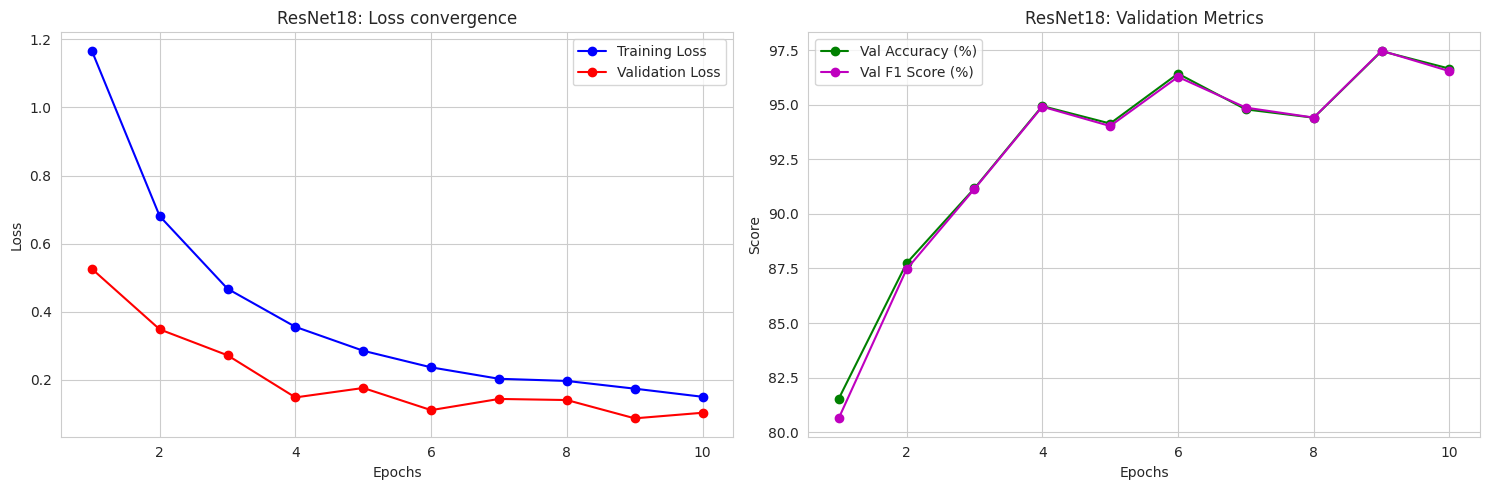

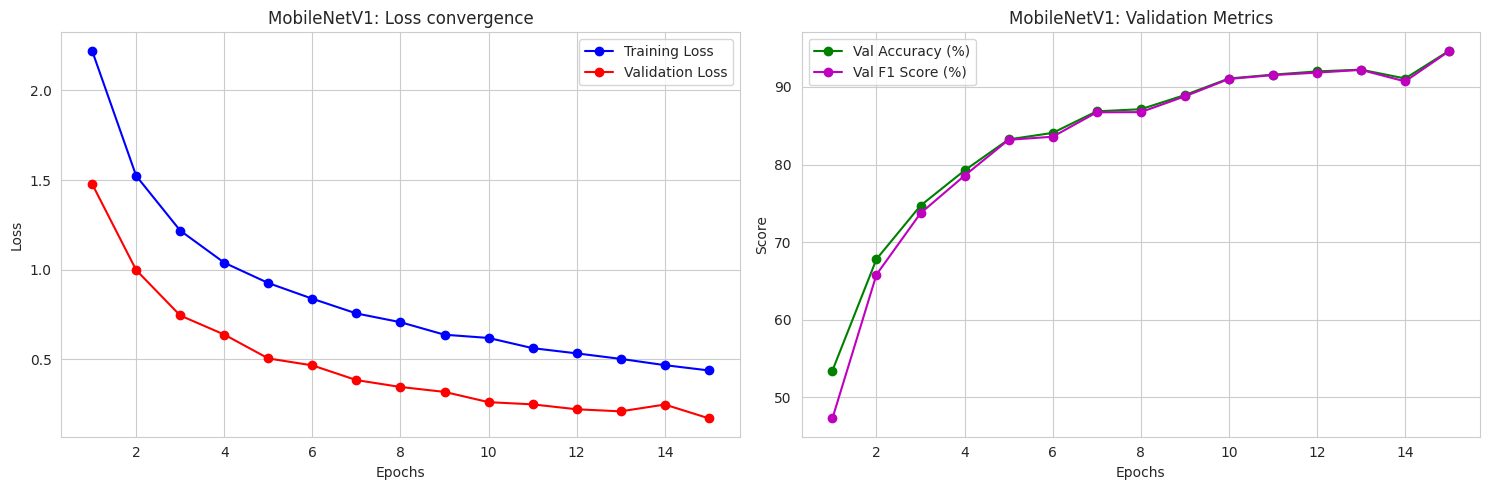

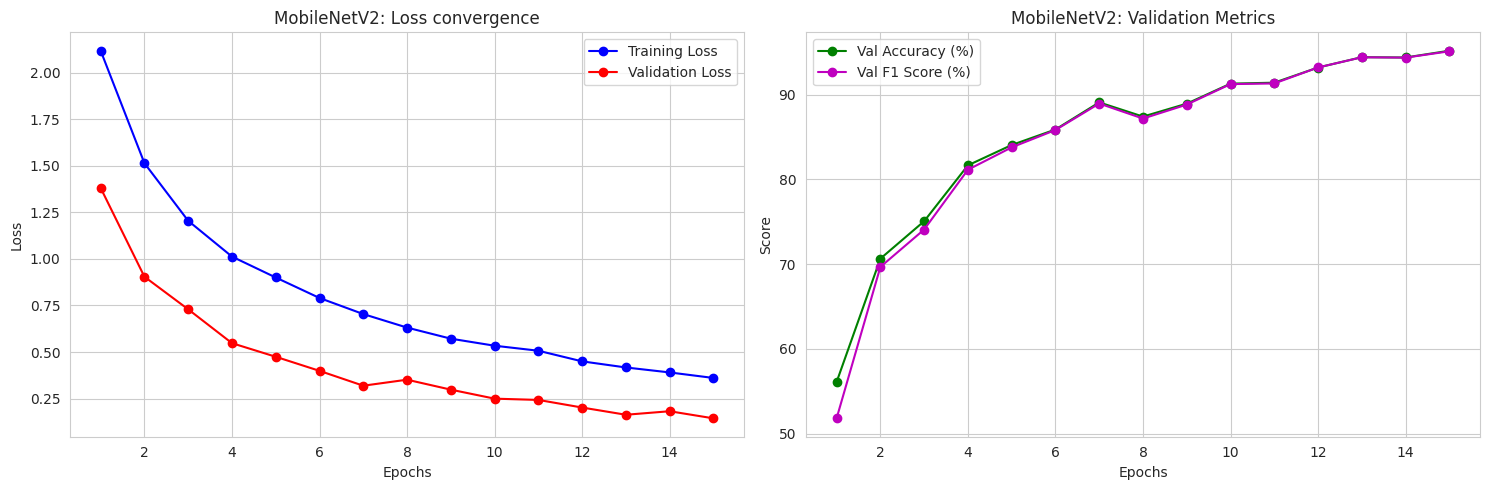

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better looking plots
sns.set_style("whitegrid")

def plot_training_history(histories):
    for model_name, history in histories.items():
        epochs = range(1, len(history['train_loss']) + 1)
        
        plt.figure(figsize=(15, 5))
        
        # Plot 1: Loss Curves (Convergence)
        plt.subplot(1, 2, 1)
        plt.plot(epochs, history['train_loss'], 'b-o', label='Training Loss')
        plt.plot(epochs, history['val_loss'], 'r-o', label='Validation Loss')
        plt.title(f'{model_name}: Loss convergence')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        
        # Plot 2: Metrics (Accuracy & F1)
        plt.subplot(1, 2, 2)
        # Normalize F1 to percentage (0-100) to match Accuracy scale for easier viewing
        f1_percentage = [x * 100 for x in history['val_f1']] 
        
        plt.plot(epochs, history['val_acc'], 'g-o', label='Val Accuracy (%)')
        plt.plot(epochs, f1_percentage, 'm-o', label='Val F1 Score (%)')
        plt.title(f'{model_name}: Validation Metrics')
        plt.xlabel('Epochs')
        plt.ylabel('Score')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

# Run the plotting function
plot_training_history(model_histories)

### Here we will plot the Confusion Matrix
The Confusion Matrix is a 2D Matrix where the rows represent the actual (true) classes and the columns represent the predicted classes. It allows us to see exactly where the model is getting "confused."
- The Diagonal: Represents correct predictions (e.g., An Apple_Scab image predicted as Apple_Scab).

- The Off-Diagonal: Represents errors. For example, if the cell at row Apple_Scab and column Apple_Black_Rot has a high number, it means the model frequently mistakes Scab for Black Rot.

In a multi-class dataset, this is far more useful than a single accuracy number because it tells us which specific diseases look similar in the model's view.

Generating Confusion Matrix for ResNet18...


Eval ResNet18: 100%|██████████| 82/82 [00:04<00:00, 18.07it/s]


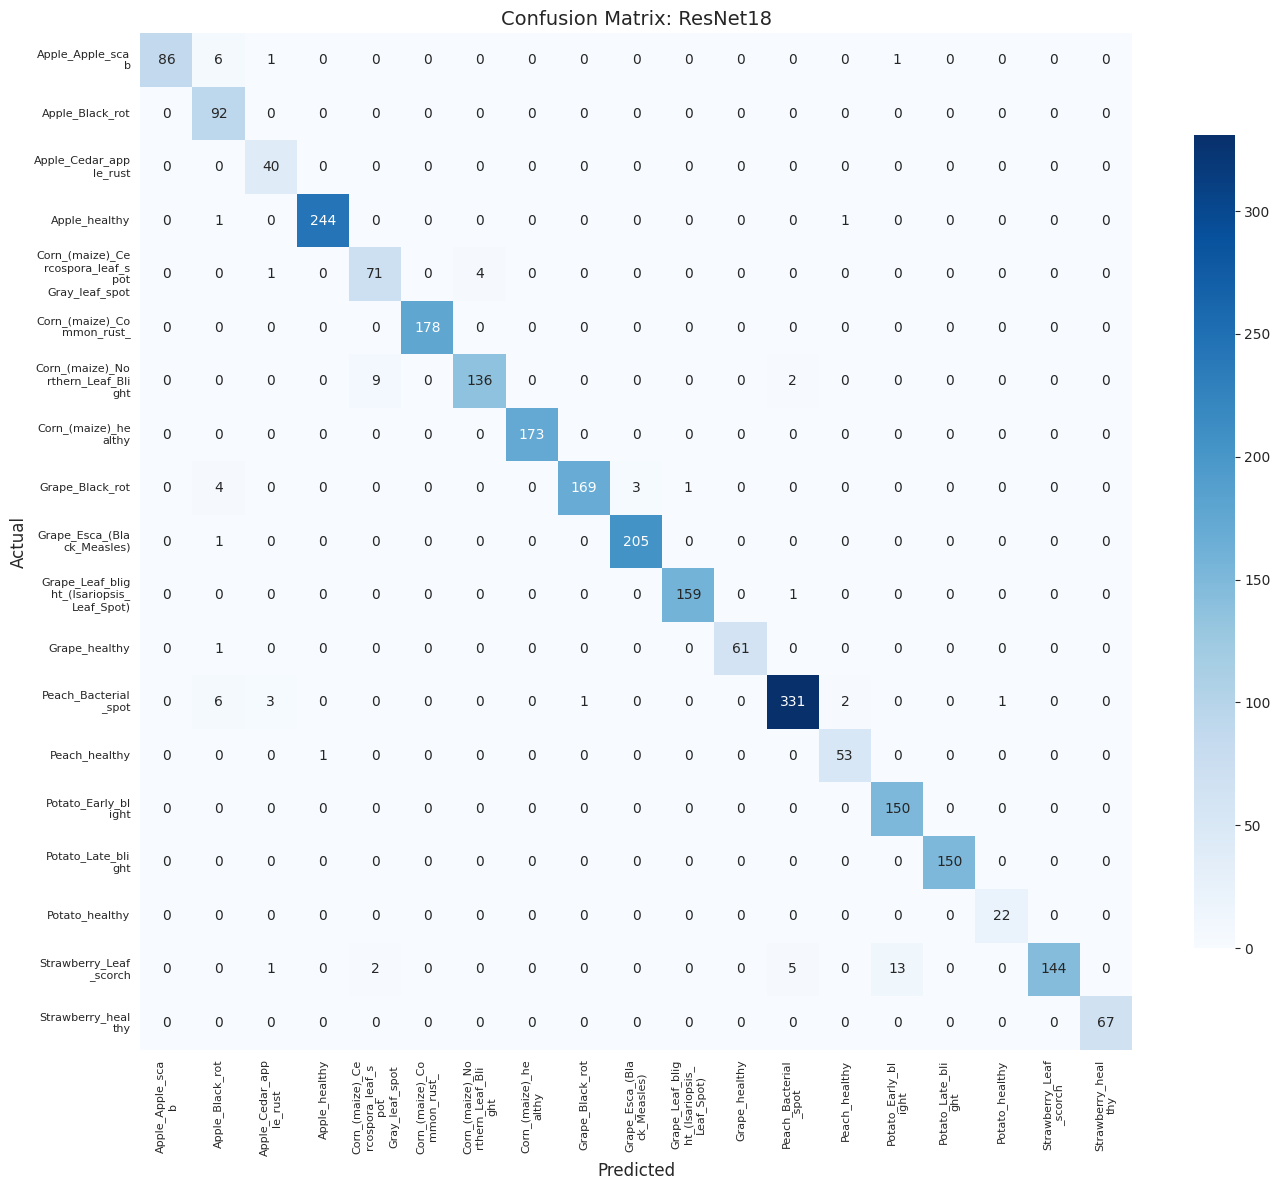

Generating Confusion Matrix for MobileNetV1...


Eval MobileNetV1: 100%|██████████| 82/82 [00:04<00:00, 18.58it/s]


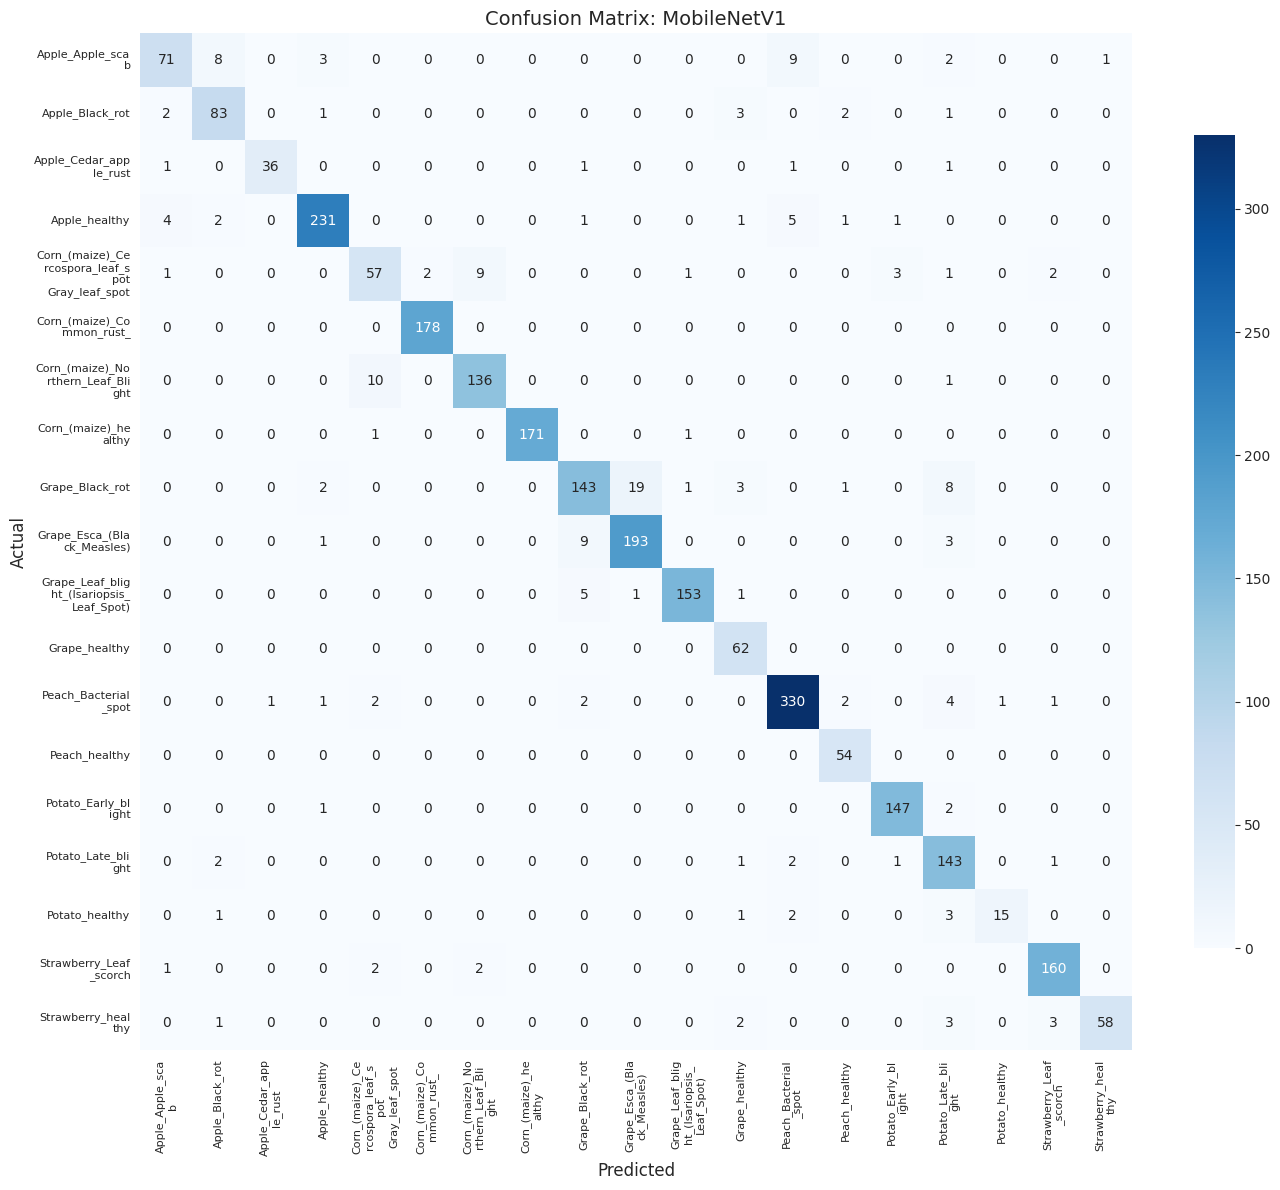

Generating Confusion Matrix for MobileNetV2...


Eval MobileNetV2: 100%|██████████| 82/82 [00:05<00:00, 16.38it/s]


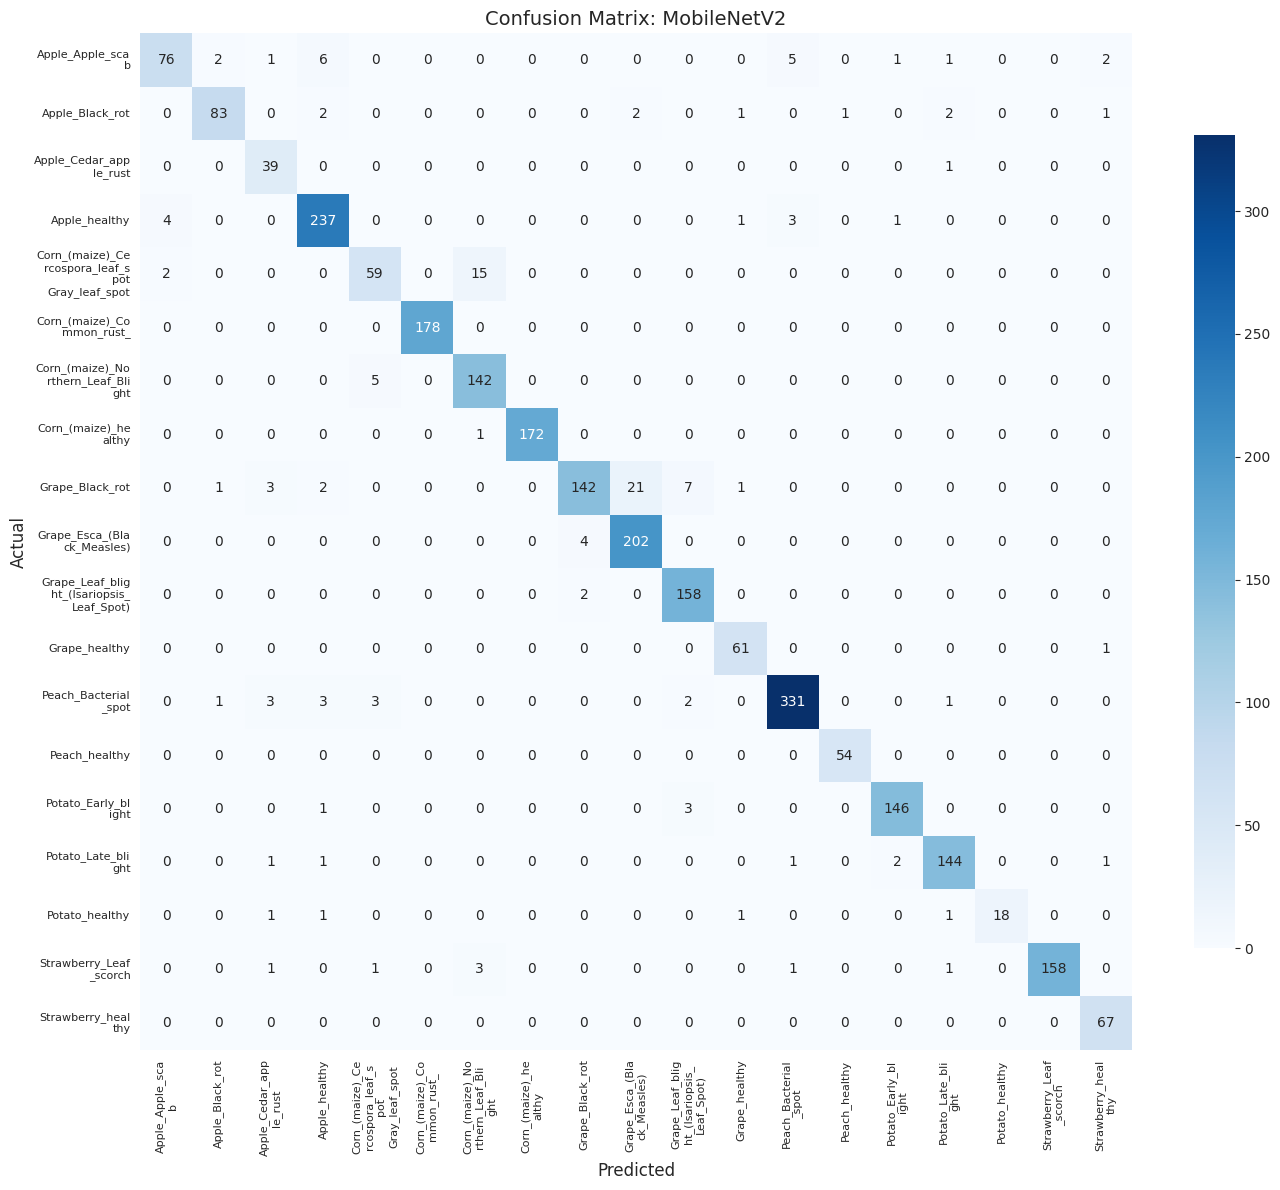

In [15]:
from sklearn.metrics import confusion_matrix
import numpy as np
import textwrap

def plot_confusion_matrices(model_configs, models_to_test):
    # Get class names from the dataset
    class_names = [f"{row.plant}_{row.disease}" for row in master_classes.itertuples()]
    
    # Wrap long class names to multiple lines (wrap at 15 characters)
    wrapped_names = [textwrap.fill(name, width=15) for name in class_names]
    
    for config in model_configs:
        name = config["name"]
        if name not in models_to_test:
            continue
            
        print(f"Generating Confusion Matrix for {name}...")
        
        # Load best model
        model = config["model"].to(device)
        load_path = os.path.join(MODEL_DIR, f"{name}_best.pth")
        model.load_state_dict(torch.load(load_path))
        model.eval()
        
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for images, labels in tqdm(test_loader, desc=f"Eval {name}"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        # Compute Matrix
        cm = confusion_matrix(all_labels, all_preds)
        
        # Plotting
        plt.figure(figsize=(14, 12))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=wrapped_names, yticklabels=wrapped_names,
                    cbar_kws={'shrink': 0.8})
        plt.xlabel('Predicted', fontsize=12)
        plt.ylabel('Actual', fontsize=12)
        plt.title(f'Confusion Matrix: {name}', fontsize=14)
        plt.xticks(rotation=90, fontsize=8)
        plt.yticks(rotation=0, fontsize=8)
        plt.tight_layout()
        plt.show()

# Run the confusion matrix plotting
plot_confusion_matrices(model_configs, models_to_test)

In [17]:
# Final model size and parameter count report
def get_model_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    size_all_mb = (param_size + buffer_size) / 1024**2
    return size_all_mb

print(f"{'Model':<15} | {'Params (M)':<12} | {'Size (MB)':<10}")

models_to_get_size = ["ResNet18", "MobileNetV1", "MobileNetV2", "VGG16"]

for config in model_configs:
    name = config["name"]
    if name not in models_to_get_size:
        continue
    model = config["model"]
    # Move to CPU for static calculation just in case
    model.cpu()
    
    num_params = sum(p.numel() for p in model.parameters()) / 1e6
    size_mb = get_model_size(model)
    
    print(f"{config['name']:<15} | {num_params:<12.2f} | {size_mb:<10.2f}")

Model           | Params (M)   | Size (MB) 
ResNet18        | 11.19        | 42.71     
MobileNetV1     | 3.23         | 12.39     
MobileNetV2     | 2.25         | 8.71      
